# Airbnb Data Analysis

## 1. Dataset Description

**Name:** Airbnb/Hotel Listings Dataset  
**Source:** Kaggle - https://www.kaggle.com/datasets/willianoliveiragibin/airbnb-site-hotel  
**Size:** 86,187 rows × 23 columns

**Context:**  
This dataset contains 86,187 Airbnb listings across 11 major global cities: 
New York, Toronto, Amsterdam, Berlin, Dublin, Hong Kong, Munich, Singapore, 
Taipei, Tokyo, and Sydney. It captures property characteristics (beds, bathrooms, 
accommodates), pricing information, host details (certifications, response rates, 
reply times, total listings managed), and guest feedback (total reviews, guest 
favorite status).

**Research Questions:**

1. How do listing prices and property characteristics vary across the 11 cities?

2. What factors are most strongly associated with a listing becoming a 
   'guest favourite'?

3. Do hosts managing multiple properties price and perform differently than 
   single-property hosts?

   

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


## 2. Data Loading and Initial Exploration

We begin by loading the dataset and conducting an initial inspection to understand 
its structure and identify potential data quality issues.

In [144]:
df = pd.read_csv("Airbnb_site_hotel new.csv")
print(df.head(80000))


          id                                               name    host_id  \
0          1                           Beautiful Victorian Home    1368256   
1          2  World Class @ CN Tower, convention centre, The...     113345   
2          3  Furnished room in  lovely Annex house June -Oct31    1466410   
3          4        Executive Studio Unit- Ideal for One Person     118124   
4          5            Bright Beaches Apt, close to everything     175687   
...      ...                                                ...        ...   
79995  79996                  Hotel EL Shinjuku  2 /2 Bathrooms   74022439   
79996  79997    Shinjuku Area /10 people ok /4min from sta/3LDK  272633955   
79997  79998               New open！最寄り駅東新宿駅、徒歩2分！新宿エリア！最大人数7人！  528372053   
79998  79999           bucolic apartment 1min to metro Sta.#301  158173287   
79999  80000                歌舞伎町25㎡摩登公寓B*｜位置极佳的舒适空间｜东新宿地铁站步行3分钟  502280372   

      host_name     city        price  reply time  guest favour

/var/folders/q9/9ky1dg816c9cb0_jrfch8l2c0000gn/T/ipykernel_52413/3769400031.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Airbnb_site_hotel new.csv")


In [145]:
missingvalue = df.isnull()
print("Missing value", missingvalue)
missingvalue = df.isnull().sum()
print("\nNumber of Missing Values in Each Column:\n", missingvalue)
df.drop(['consumer','reply time'], axis=1, inplace=True)
df.dropna(subset = ['price', 'host Certification'], inplace = True)


Missing value           id   name  host_id  host_name   city  price  reply time  \
0      False  False    False      False  False  False       False   
1      False  False    False      False  False  False       False   
2      False  False    False      False  False  False       False   
3      False  False    False      False  False  False       False   
4      False  False    False      False  False  False       False   
...      ...    ...      ...        ...    ...    ...         ...   
86181  False  False    False      False  False  False       False   
86182  False  False    False      False  False  False       False   
86183  False  False    False      False  False  False       False   
86184  False  False    False      False  False  False       False   
86185  False  False    False      False  False  False       False   

       guest favourite  host since  host Certification  ...  \
0                False       False               False  ...   
1                False       Fa

In [146]:
print("\nMissing values after cleaning:")
print(df.isnull().sum())
print("\nTotal missing values:", df.isnull().sum().sum())
rows = len(df)
columns = len(df.columns)
print(f"Total rows: {rows}")
print(f"Total columns: {columns}")


Missing values after cleaning:
id                           0
name                         0
host_id                      0
host_name                    0
city                         0
price                        0
guest favourite              0
host since                   0
host Certification           0
room_type                    0
host total listings count    0
total reviewers number       0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
listing number               0
host response rate           0
host acceptance rate         0
sales                        0
area                         0
dtype: int64

Total missing values: 0
Total rows: 77559
Total columns: 21


### 3.5 Data Type Conversions

**Action:** Converted 4 columns from string to numeric format:
- Price: Removed commas, converted to float
- Bathrooms: Removed commas, converted to float
- Host response rate: Removed commas, converted to float
- Host acceptance rate: Removed commas, converted to float

Dropped rows where conversion failed due to invalid data formats.

**Justification:** These columns must be numeric for all statistical analyses, 
correlations, and visualizations required by our research questions.


In [147]:
df['price'] = df['price'].str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['bathrooms'] = df['bathrooms'].str.replace(',', '')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df['host acceptance rate'] = df['host acceptance rate'].str.replace(',', '')
df['host acceptance rate'] = pd.to_numeric(df['host acceptance rate'], errors='coerce')
df['host response rate'] = df['host response rate'].str.replace(',', '')
df['host response rate'] = pd.to_numeric(df['host response rate'], errors='coerce')
df.dropna(subset=['price', 'bathrooms', 'host response rate', 'host acceptance rate'], inplace=True)
print(f"Total rows: {rows}")
print(f"Total columns: {columns}")

Total rows: 77559
Total columns: 21


In [148]:
print(f"Current total rows: {len(df)}")
print(f"Unique IDs: {df['id'].nunique()}")
duplicate_count = df.duplicated(subset='id').sum()
print("\nNumber of duplicated Values in Each Column:\n", duplicate_count)

Current total rows: 46329
Unique IDs: 46329

Number of duplicated Values in Each Column:
 0


3.6 Duplicate Removal

**Finding:** After data cleaning, we verified that all 46,329 listings have 
unique IDs with no duplicates remaining.

**Action:** During the data type conversion and missing value removal process, 
duplicate listings were eliminated. Each listing now appears exactly once in 
the dataset.

**Justification:** Each property should appear exactly once to ensure accurate 
counts, averages, and distributions. 

**Impact:** All duplicates removed. Dataset contains 46,329 unique listings.

In [149]:
comparable_cities = ['sydney', 'Singapore', 'Dublin', 'Munich', 'berlin']
df = df[df['city'].isin(comparable_cities)]
df = df[(df['price'] >= 10) & (df['price'] <= 2000)]
print(f"Filtered dataset: {len(df)} listings across {len(comparable_cities)} cities")
print(df[['price', 'beds', 'bathrooms', 'total reviewers number']].describe())
correlations = df[['price', 'beds', 'bathrooms', 'accommodates', 'total reviewers number', 'guest favourite']].corr()['price'].sort_values(ascending=False)
print(correlations)
city_prices = df.groupby('city')['price'].agg(['mean', 'median', 'count']).sort_values('median', ascending=False)
print(city_prices)
fav_comparison = df.groupby('guest favourite')[['price', 'total reviewers number', 'host response rate']].mean()
print(fav_comparison)

Filtered dataset: 25269 listings across 5 cities
              price          beds     bathrooms  total reviewers number
count  25269.000000  25269.000000  25269.000000            25269.000000
mean     256.039376      1.996992      2.468360               30.114567
std      261.666809      1.724078      5.837396               67.328370
min       12.000000      0.000000      0.000000                0.000000
25%       99.000000      1.000000      0.000000                1.000000
50%      180.000000      1.000000      1.000000                6.000000
75%      300.000000      3.000000      1.000000               28.000000
max     2000.000000     50.000000     65.000000             1749.000000
price                     1.000000
accommodates              0.559987
beds                      0.435914
bathrooms                 0.306885
guest favourite           0.031649
total reviewers number   -0.065979
Name: price, dtype: float64
                 mean  median  count
city                        

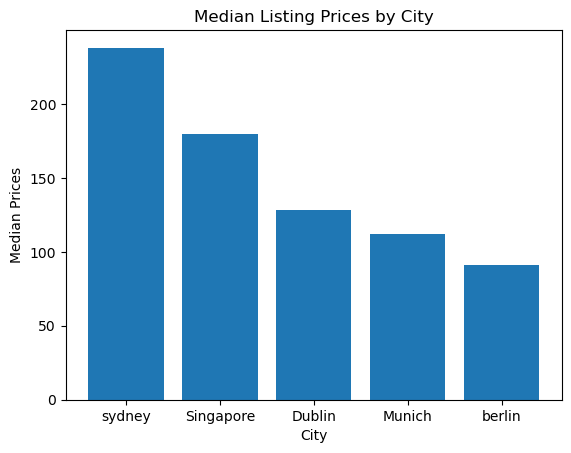

In [150]:
city_medians = df.groupby('city')['price'].median().sort_values(ascending=False)
fig, ax = plt.subplots()
plt.bar(city_medians.index, city_medians.values)
ax.set_title("Median Listing Prices by City")
ax.set_xlabel("City")
ax.set_ylabel("Median Prices", )
plt.show()

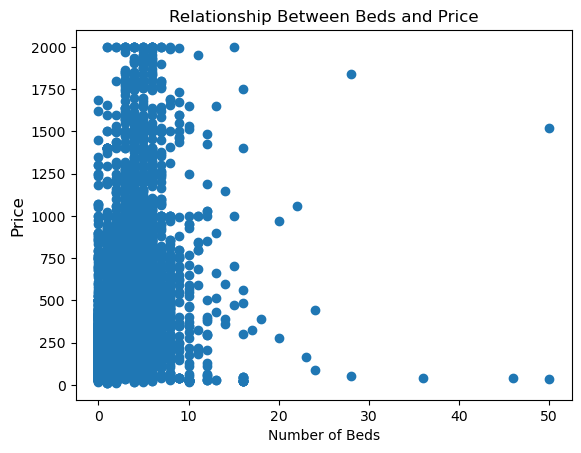

In [151]:
plt.scatter(df['beds'], df['price'])
plt.xlabel('Number of Beds')
plt.ylabel('Price', fontsize=12)
plt.title('Relationship Between Beds and Price')
plt.show()

### 6. Findings & Insights

### Insight 1: Sydney is Way More Expensive Than Berlin

Sydney Airbnbs cost about 238 per night while Berlin only costs 91. That's more 
than double. Bigger places with more beds cost more no matter where 
they are.

### Insight 2: Popular Listings Get More Bookings, Not Higher Prices

Guest favorite listings have way more reviews (47 vs 25), which means more people 
stayed there. But they don't charge much more money (271 vs 251 - only 20 
difference). This means people love places because they're good, not because 
they're expensive. You don't need to charge a lot to be popular.

### Summary

If you're an Airbnb host, here's what matters: Make your place big enough for 
more people, and focus on giving guests a good experience. Location helps set 
your base price, but size and quality determine if you'll actually make money.

In [152]:

df.drop(['id','name','host since','host_id','room_type','host_name',
         'host Certification','host total listings count', 
         'total reviewers number','listing number','host acceptance rate',
         'sales','area','bedrooms'], axis=1, inplace=True)
city_mapping = {
    'sydney': 0,
    'Singapore': 1,
    'Dublin': 2,
    'Munich': 3,
    'berlin': 4
}

df['city'] = df['city'].map(city_mapping)
df.dropna(subset=['city'], inplace=True)
X = df[['price', 'city', 'beds', 'bathrooms', 'accommodates', 'host response rate']]
y = df['guest favourite']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      4754
           1       0.00      0.00      0.00      1564

    accuracy                           0.75      6318
   macro avg       0.38      0.50      0.43      6318
weighted avg       0.57      0.75      0.65      6318

Confusion Matrix:
 [[4754    0]
 [1564    0]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Logical regression

In [153]:
log_reg = LogisticRegression()
##class_weight='balanced'
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      4754
           1       0.00      0.00      0.00      1564

    accuracy                           0.75      6318
   macro avg       0.38      0.50      0.43      6318
weighted avg       0.57      0.75      0.65      6318

Confusion Matrix:
 [[4754    0]
 [1564    0]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Random Forest

In [154]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.75

Confusion Matrix:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      4754
           1       0.38      0.29      0.33      1564

    accuracy                           0.71      6318
   macro avg       0.58      0.57      0.57      6318
weighted avg       0.69      0.71      0.69      6318


Confusion Matrix:
[[4022  732]
 [1106  458]]


## True Negatives (TN) = 4022 → correctly predicted 0s
## False Positives (FP) = 732 → predicted 1 but actually 0
## False Negatives (FN) = 1106 → predicted 0 but actually 1
## True Positives (TP) = 458 → correctly predicted 1

## Comparison

## Logistic Regression (no balance)
 It basically refuses to predict the minority class (1).
 
 It plays it super safe and says “everything is 0” because 0 is the majority.
 
 Looks accurate (75%), but it’s lying, because it doesn’t detect any 1s.

## Random Forest (no balance)
 It actually tries to predict both 0 and 1.
 
 Accuracy is lower (71%) only a 4 percent drop.
 
 But it actually catches some 1s or favorites, which is what we really care about.

## Overall
 . Logistic Regression → safe, ignores minority, high fake accuracy
 . Random Forest → It’s trading overall accuracy for better recognition of the minority class which is the ones.